# Training Linear Models  <a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro

In this notebook we will go over both theory and examples of training models for regression and classification.

1. [Linear Regression](#linreg)
2. [Gradient Descent](#gradient)
    1. [Batch Gradient Descent](#bgd)
    2. [Stochastic Gradient Descent](#sgd)
    3. [Mini-batch Gradient Descent](#mbgd)
3. [Polynomial Regression](#polyreg)
4. [Learning Curves](#learn)
5. [Regularized Linear Models](#regular)
    1. [Ridge Regression](#ridge)
    2. [Lasso Regression](#lasso)
    3. [Elastic Net Regression](#elastic)
    4. [Early Stopping](#early)
6. [Logistic Regression](#logistic)
4. [Explore the data](#explore)
5. [Training and test sets](#traintest)
6. [Visualize the training data](#visualize)
7. [Feature engineering testing](#featureng)
8. [Data preperation](#preperation)
9. [Transformer pipelines](#pipelines)
10. [Select and Train a Model](#firstmodels)
11. [Model baselines](#baselines)
12. [Fine-tuning hyperparameters](#gridsearch)
13. [Analyzing the best estimators](#bestestimators)
14. [Evaluate system on test data](#evaluatetesth)
14. [Summary](#summary)

In [1]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## 1. Linear Regression <a class="anchor" id="linreg"></a>

[[back to top]](#top)

A linear model makes predictions by computing a weighted sum of input features, with a bias term (intercept):

$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n $, where 

* $\hat{y}$ is the predicted value
* $n$ is the number of features/attributes
* $x_i$ is the i<sup>th</sup> feature
* $\theta_j$ is the model parameter with both the bias term $\theta_0$ and the weighted terms

We can vectorize the equation so it is more succint,

$\hat{y} = h_\theta (x) = \theta^{T}\cdot x$, where

$h_\theta$ is the linear operator function (hypothesis) operating on the feature array $x$ and is equal to the dot product of parameter vector $\theta$ transpose with $x$. The feature vector, $x$, contains $x_0$ to $x_n$ with $x_0$ always equal to 1.

The common measure for how well the model performs (or how poorly it fits the data), is the Mean Square Error (MSE). Minimizing the MSE, also minimizes the RMSE. For linear regression the MSE for hypothesis, $h_\theta$ with a training set $X$ is equal to:

$MSE(X,h_0) = \frac{1}{m} \sum^{m}_{i=1}(\theta^T \cdot x^{(i)} - y^{(i)})^2$, where

$m$ is the number of training instances. The value of $\theta$ that minimizes the MSE or cost function, can be found algebraically.

### Normal Equation
The expression for the value $\hat{\theta}$ that minimizes the cost function above, is called the Normal Equation and is equal to:

$\hat{\theta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y$, where

$y$ is the vector containing the target values for $m$ instances.

#### Example:

Let's generate some noisy data and test the previous equation for estimating the best-fit linear parameters.

Text(0,0.5,'$y$')

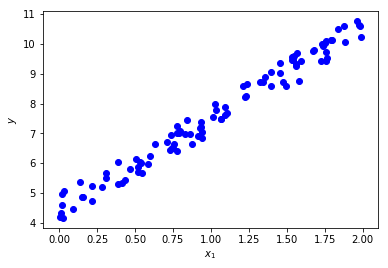

In [2]:
X= 2*np.random.rand(100,1)
y= 4 + 3*X + np.random.rand(100,1)

#Make scatter of instances and target
plt.scatter(X,y,color='b');plt.xlabel('$x_1$');plt.ylabel('$y$')

Next let us compute $\hat{\theta}$ using the prior equation, and plot the fit result. First we have to add a column of 1's to $X$.

theta =  [[ 4.37588837]
 [ 3.1548269 ]]


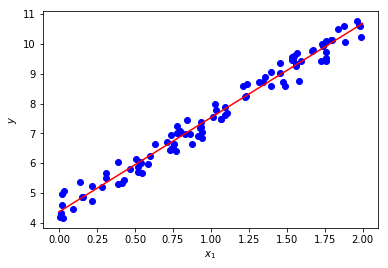

In [3]:
# Normal equation
Xs = np.c_[np.ones((100,1)),X]
theta_hat = np.linalg.inv(Xs.T.dot(Xs)).dot(Xs.T).dot(y) 
print("theta = ",theta_hat)

# Plot predictions over the range x1=[0,2]
X_new  = np.array([[0],[2]])
X_news = np.c_[np.ones((2,1)),X_new] # add 1s
y_pred = X_news.dot(theta_hat)
plt.scatter(X,y,color='b');plt.xlabel('$x_1$');plt.ylabel('$y$')
plt.plot(X_new,y_pred,'r-')


`sklearn` does all of this with the class `LinearRegression()`:

In [5]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X,y)
print('Intercept: ', LR.intercept_)
print('Coefficient: ', LR.coef_)
# Predict
pred = LR.predict(X_new)
print('Predictions: ',pred)

Intercept:  [ 4.37588837]
Coefficient:  [[ 3.1548269]]
Predictions:  [[  4.37588837]
 [ 10.68554217]]


This is the exact same parameters and predictions we found but in a nice and easy class.

### Computational Complexity

Solving the Normal Equation involves computing the inverse of $(X^T\cdot X)$ which is an $n\times n$ matrix, with $n$ being the number of features. The computational complexity of inverting the matrix is at least $\mathcal{O}(n^{2.4)}$. So if the number of features are doubled then the computational time increases by at least $2^{2.4}=5.3$. The Normal Equation is known to get slow when the number of features exceeds 100,000.

The equation is linear though with regards to the number of instances, $m$, in the training set, $\mathcal{O}(m)$. It can handle large training sets efficiently if they can fit in memory. Predictions are also very fast; as the computational time is linear with the number of instances to make predictions on and the number of features.

What if there are a large number of features that cannot fit into memory? 

## 2. Gradient Descent <a class="anchor" id="gradient"></a>
[[back to top]](#top)

**Gradient Descent** generally finds optimal solutions by tweaking parameters iteratively in order to minimize a cost function. It is analogous to hiking blind and trying to find the fastest route down the mountain by feeling for the steepest slope to go downhill. Gradient Descent measures the local gradient of the error function with respect to the parameter vector $\theta$ and goes in the direction of descending gradient. At a gradient of zero a minimum has been reached.

Start by initializing $\theta$ with random values and then improve gradually by taking a step attempting to decrease the cost function (MSE) until it converges on a minimum. The size of the step is important, too large and you might miss the minimum and never converge, and too small and it will a long time to converge. The size of the step is also called the **learning rate** parameter.

Another potential problem is if there exists local minima and the gradient descent never reaches the global minimum of the cost function. The MSE for linear regression is a convex function, so there are no local minima and is a continuous function with a slope that doesn't change abruptly. Gradient Descent is guaranteed to find parameters close to the global minimum (if the learning rate isn't too high). Another important consequence is that the scaling of the features matters, which can be done by `StandardScaler()` class.

### 2.A Batch Gradient Descent <a class="anchor" id="bgd"></a>

To implement Gradient Descent, you need to compute the gradient of the cost function with regards to each model parameter $\theta_j$. So you have to calculate how much the cost function will change if $\theta_j$ is changed a little. This is also a partial derivative, for the MSE it is:

$\frac{\partial}{\partial \theta_j} MSE(\theta) = \frac{2}{m} \sum^{m}_{i=1}(\theta^T \cdot x^{(i)} - y^{(i)})x^{(i)}_j$

The individual gradients can be computed all at once. The gradient vector, $\nabla_\theta MSE(\theta)$ by

$$\nabla_\theta MSE(\theta) = \begin{pmatrix}{}
\frac{\partial}{\partial \theta_0} MSE(\theta)  \\
\frac{\partial}{\partial \theta_1} MSE(\theta)  \\
                  \vdots                         \\
\frac{\partial}{\partial \theta_n} MSE(\theta)  \\
\end{pmatrix}  =  \frac{2}{m}X^T \cdot (X\cdot\theta - y)
$$

This is why the method is called **Batch Gradient Descent** as the each step requires calculations over the entire training set,  $X$. It is very slow on large training sets, but scales well with number of features. Using Batch Gradient Descent on a Linear Regression problem with thousands of features is much faster than using the Normal Equation!

Once the gradient vector is calculated, $\nabla_\theta MSE(\theta)$, we take a step in the opposite direction to go downhill, thus subtracting $\nabla_\theta MSE(\theta)$ from $\theta$. The 'size' of the step taken is determined by the **learning rate**, $\eta$:

$\theta^{(next)} = \theta - \eta \nabla_\theta MSE(\theta)$

We can look at a quick implementation of batch gradient descent:

In [6]:
# Gradient Descent parameters
eta = 0.1
n_iterations = 1000
m = 100
# Intialize theta
theta0 = np.random.randn(2,1) # random initialization
def BGD(Xs,m,theta,eta,n_iterations):
    thetas = [];thetas.append(theta)
    for iteration in range(n_iterations):
        gradients = 2/m *Xs.T.dot(Xs.dot(theta) - y)
        theta =theta - eta*gradients
        thetas.append(theta)
    return thetas
thetas_bgd = BGD(Xs,m,theta0,eta,n_iterations)
print('Batch Gradient Descent parameters:')
print(thetas_bgd[-1])

Batch Gradient Descent parameters:
[[ 4.37588837]
 [ 3.1548269 ]]


Let's investigate how changing the learning rate can affect the final parameters found:

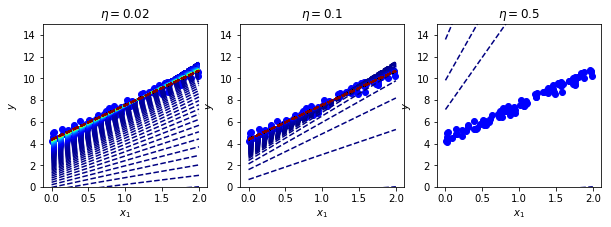

In [7]:
etas = [0.02,0.1,0.5]
fig,axes = plt.subplots(1,len(etas),figsize=[10,3])
for eta,ax in zip(etas,axes.ravel()):
    thetas = BGD(Xs,m,theta0,eta,n_iterations)
    # Plot thetas by color code
    ax.scatter(X,y,color='b');ax.set_xlabel('$x_1$');ax.set_ylabel('$y$')
    cm_subsection = np.linspace(0.0, 1.0, len(thetas)) 
    colors = [ cm.jet(x) for x in cm_subsection ]
    for i,(theta,color) in enumerate(zip(thetas,colors)):
        y_pred = X_news.dot(theta)
        ax.plot(X_new,y_pred,color=color,ls='--')
    ax.set_ylim([0,15])
    ax.set_title('$\eta=${}'.format(eta))

On the left the learning rate is too slow, it eventually reaches the solution but takes more iterations. In the middle, the learning rate looks good as it converges in a few iterations. On the right the learning rate is too high and it misses the solution and diverges away.

We can use `sklearn` `GridSearchCV` or `RandomizedSearchCV` to find the optimal learning rate. But how to set the `n_iterations` parameter? If it's too high then wasting computational time if the solution converges quickly, but if it's too low then it might not converge at the end. One solution is to set a high number of iterations and then stop the algorithm when the gradient vector becomes very small, when it's norm becomes smaller than some `tolerance`, $\epsilon$. This happens when Gradient Descent has almost reached the minimum.

#### Convergence Rate
When the cost function is convex and the slope does not change abruptly (like for MSE) it can be shown that Batch Gradient Descent with a fixed learning rate has a convergence rate of:

$\mathcal{O}(\frac{1}{iterations})$

So if the tolerance, $\epsilon$ by 10, then the algorithm will have to run about 10 times more iterations.

### 2.B Stochastic Gradient Descent <a class="anchor" id="sgd"></a>

As noted earlier, a limitation of Batch Gradient Descent is that it uses the whole training set to compute the gradients at every step, and is slow when the training set is large. At the opposite end, **Stochastic Gradient Descent** picks a random instance in the training set at every step and computes the gradients based only on the single instance. There is thus less data to manipulate at each iteration, and training on large datasets possible. Compared to BGD, SGD bounces around more decreasing only on average, and over time it will end close to the minimum, but never settling on the true minimum optimal parameters

When the cost function is complex and has local minima, SGD has a better chance than BGD for jumping out of the minima and finding the global minimum. The advantage is that it can escape from local minima but has the the disadvantage that it can never settle at the minimum. There is a process to address this called *simulated annealing* where the learning rate is large at first (to escape local minima) and then gets smaller so that it can converge on the global minimum. The function that determines the learning rate is call the **learning schedule** and is important to not decrease the rate too quickly or too fast.

We will construct a scheduler for SGD:


Text(0.5,1,'Stochastic Gradient Descent last 10 steps')

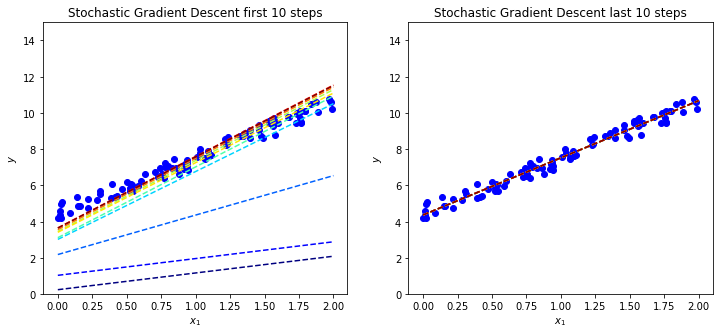

In [12]:
#Parameters
n_epochs =50
t0,t1 = 5, 50 # learning rate hyperparameters 

def learning_schedule(t): # as number of epochs increases, learing rate decreases
    return t0/(t+t1)

# Theta initialization
theta0 = np.random.randn(2,1) 
thetas_sgd = [theta0]

# Stochastic Gradient Descent
for epoch in range(n_epochs):
    if epoch == 0: theta=theta0
    for i in range(m):
        random_index = np.random.randint(m) #select random instance
        xi = Xs[[random_index],:]
        yi = y[random_index]
        gradients = 2*xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta- eta*gradients
        thetas_sgd.append(theta)

# Make plot of first and last 10 steps
fig,(ax1,ax2) =plt.subplots(1,2,figsize=[12,5])
# Plot every 100s theta solution
[ax.scatter(X,y,color='b') for ax in [ax1,ax2]]
[ax.set_xlabel('$x_1$') for ax in [ax1,ax2]];[ax.set_ylabel('$y$') for ax in [ax1,ax2]]
cm_subsection = np.linspace(0.0, 1.0, 10) 
colors = [ cm.jet(x) for x in cm_subsection ]
#First 10 steps
for i,(theta,color) in enumerate(zip( thetas_sgd[0:10],colors)):
    y_pred = X_news.dot(theta)
    ax1.plot(X_new,y_pred,color=color,ls='--')
#Last 10 steps
for i,(theta,color) in enumerate(zip( thetas_sgd[-10:],colors)):
    y_pred = X_news.dot(theta)
    ax2.plot(X_new,y_pred,color=color,ls='--')
[ax.set_ylim([0,15]) for ax in [ax1,ax2]]
ax1.set_title('Stochastic Gradient Descent first 10 steps')
ax2.set_title('Stochastic Gradient Descent last 10 steps')

Since the instances are picked randomly, some instances  may be picked several times per epoch while others may not be picked at all. One method to ensure all instances are used, is to shuffle all of the training set, go through it instance by instance and then shuffle it again before the next epoch. Though this generally converges more slowly.

To perform Linear Regression using SGD with `sklearn`, there is the `SGDRegressor` class which by default optimizes the squared error cost function. The following code runs 50 `epochs` starting with a learning rate ($\eta_0$=0.1) and using a default learning scheduler (different from one we made), with no regularization (`penalty=None`):


In [87]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Train model
sgd_reg = SGDRegressor(n_iter=50,penalty=None,eta0=0.1)
sgd_reg.fit(X,y.ravel())
# Predictions
y_pred = sgd_reg.predict(X)
# Calculate MSE
sgdreg_mse = mean_squared_error(y,y_pred)
print('MSE of training data:',sgdreg_mse)
print('Intercept: ', sgd_reg.intercept_)
print('Coefficient: ',sgd_reg.coef_)

MSE of training data: 0.0797472151215
Intercept:  [ 4.4190832]
Coefficient:  [ 3.09841392]


### 2.C Mini-batch Gradient Descent  <a class="anchor" id="mbgd"></a>
At each step, instead of computing gradients based on the full training set (as in BGD) or based on a single instance (as in SGD), **Mini-batch Gradient Descent** (MbGD) computes gradients on a small random set of instances. The advantage is that you can get a performance boost from hardware optimization of matrix operations.



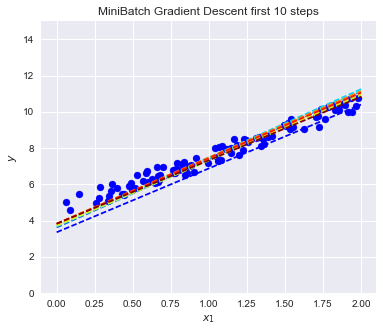

In [94]:
#Parameters
n_epochs =50
t0,t1 = 10, 1000 # learning rate hyperparameters 
t=0
minibatch_size = 20

# Theta initialization
theta0 = np.random.randn(2,1) 
thetas_mbgd = [theta0]

# Mini-batch Gradient Descent
for epoch in range(n_epochs):
    if epoch == 0: theta=theta0
    #Shuffle training set before each epoch
    shuffled_indices = np.random.permutation(m)
    Xs_shuffled = Xs[shuffled_indices]
    y_shuffled = y[shuffled_indices]    
    for i in range(0, m, minibatch_size):
        t+=1
        xbatch = Xs_shuffled[i:i+minibatch_size]; ybatch = y_shuffled[i:i+minibatch_size]
        gradients = 2*xbatch.T.dot(xbatch.dot(theta)-ybatch)
        eta = learning_schedule(t)
        theta = theta- eta*gradients
        thetas_mbgd.append(theta)

# Make plot of first 10 steps
fig,ax=plt.subplots(1,1,figsize=[6,5])
# Plot every 100s theta solution
ax.scatter(X,y,color='b');ax.set_xlabel('$x_1$');ax.set_ylabel('$y$')
cm_subsection = np.linspace(0.0, 1.0, 10) 
colors = [ cm.jet(x) for x in cm_subsection ]
for i,(theta,color) in enumerate(zip( thetas_mbgd[0:10],colors)):
    y_pred = X_news.dot(theta)
    ax.plot(X_new,y_pred,color=color,ls='--')
ax.set_ylim([0,15])
ax.set_title('MiniBatch Gradient Descent first 10 steps')

Can see Mini-batch converges more quickly that SGD, as the progress in parameter space is less erratic than SGD. But like BGD is may be hard to escape local minima.

We can compare the path in parameter space for each of the 3 Gradient Descent algorithms we looked at:

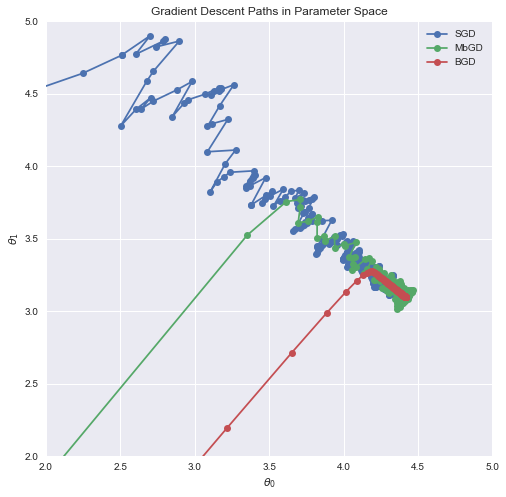

In [102]:
fig,ax=plt.subplots(1,figsize=[8,8])
# Stochastic
thetas_sgd =np.array(thetas_sgd)
ax.plot(thetas_sgd[:,0],thetas_sgd[:,1],'o-',label='SGD')
# Mini-batch
thetas_mbgd =np.array(thetas_mbgd)
ax.plot(thetas_mbgd[:,0],thetas_mbgd[:,1],'o-',label='MbGD')
# Batch
thetas_bgd =np.array(thetas_bgd)
ax.plot(thetas_bgd[:,0],thetas_bgd[:,1],'o-',label='BGD')
ax.set_xlabel(r'$\theta_0$');ax.set_ylabel(r'$\theta_1$')
ax.legend()
ax.set_xlim([2,5]);ax.set_ylim([2,5])
ax.set_title('Gradient Descent Paths in Parameter Space')

We can see that BGD actually stops at the minimum while SGD and MbGD  jump around the optimal  parameters.       

## 3. Polynomial Regression <a class="anchor" id="polyreg"></a>
[[back to top]](#top)

One way to fit a linear model to nonlinear data is to use polynomial regression where we can add powers of each feature as a new set of features.

Let's generate some nonlinear data by adding noise to a quadratic function:

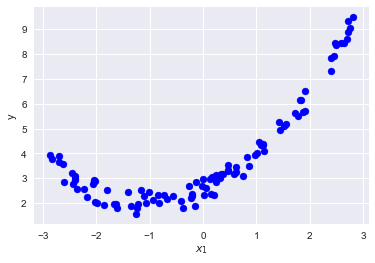

In [107]:
# Generate 100 instance training data
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5*X**2+X+2 +np.random.rand(m,1)

#Plot
plt.scatter(X,y,color='b');plt.xlabel('$x_1$');plt.ylabel('y')

Can use `sklearn`'s `PolynomialFeatures` class to add new features to training set:

In [110]:
from sklearn.preprocessing import PolynomialFeatures
# Set up class
poly_features = PolynomialFeatures(degree=2,include_bias=False)
# Transform
X_poly = poly_features.fit_transform(X)
print(X_poly[0])

[ 2.62936714  6.91357154]


`X_poly` contains the original data plus the square of the feature. The `include_bias` parameter adds a column vector of 1s to the data if set to `True`.

Now we can fit do a Linear Regression on `X_poly`:

Intercept:  [ 2.54890386]
Coefficients:  [[ 1.0059459   0.49325404]]


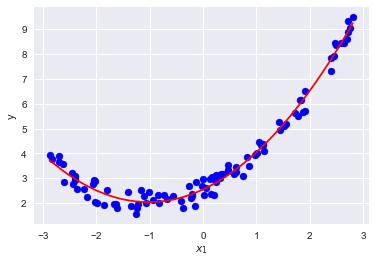

In [117]:
lr = LinearRegression()
lr_pipe =  Pipeline([("poly2",poly_features), ("lr", lr)])
lr_pipe.fit(X,y)
print('Intercept: ', lr.intercept_)
print('Coefficients: ',lr.coef_)
# Plot predictions:
xnew = np.linspace(np.min(X),np.max(X),50).reshape(50,1)
pred = lr_pipe.predict(xnew)
plt.scatter(X,y,color='b');plt.xlabel('$x_1$');plt.ylabel('y')
plt.plot(xnew,pred,color='r');plt.xlabel('$x_1$');plt.ylabel('y')

We can compare the estimated coefficients to those we used to construct the test data, and they are pretty close.

`PolynomialFeatures` can also find relationships between features,for example if we had more than 1 feature, $a$ and $b$ and did a 3rd degree polynomial, it would add features $a^2$, $a^3$, $b^2$, $b^3$, and $ab$, $a^2b$, $ab^2$. The number of features returned for a polynomial of degree $d$ and number of features $n$ is:

$features = \frac{(n+d)!}{d!n!}$

## 4. Learning Curves <a class="anchor" id="learn"></a>
[[back to top]](#top)

You can use cross-validation to get an estimate of the mode's generalized performance and compare that to training on the entire training set. If the model performs well on the training data but generalizes poorly in the C-V, then the model is overfitting. If both are poor then the model is underfitting. This is one way to tell if the model is too simple or too complex.

Another way to look at this is through *learning curves* which plots the model's performance on the training set and the validation set as a function of the training set size. To generate the learning curve, you need to train the model several times on different sized subsets of the training set. 

First we will look at 3 different models for this exercise:

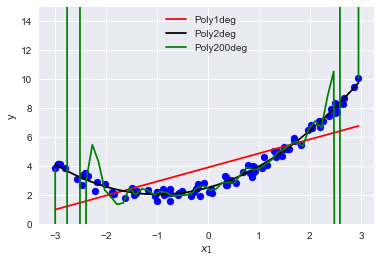

In [133]:
# Generate 100 instance training data
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5*X**2+X+2 +np.random.rand(m,1)

# 1: Linear regression
linreg = LinearRegression()
# 2: 2 deg polynomial
poly2 =  Pipeline([("poly2",PolynomialFeatures(degree=2,include_bias=False) ), 
                   ("lr", LinearRegression() )])
# 3: 50 deg polynomial
poly200 =  Pipeline([("poly200",PolynomialFeatures(degree=200,include_bias=True) ),
                     ('scaler', StandardScaler()),
                     ("lr", LinearRegression() )])

# Make plots of predictions
# Plot predictions:
xnew = np.linspace(np.min(X),np.max(X),50).reshape(50,1)
linreg.fit(X,y)
lr_pred = linreg.predict(xnew)
poly2.fit(X,y)
p2_pred = poly2.predict(xnew)
poly200.fit(X,y)
p200_pred = poly200.predict(xnew)
plt.scatter(X,y,color='b');plt.xlabel('$x_1$');plt.ylabel('y')
plt.plot(xnew,lr_pred,color='r',label='Poly1deg')
plt.plot(xnew,p2_pred,color='k',label='Poly2deg')
plt.plot(xnew,p200_pred,color='g',label='Poly200deg')
plt.ylim([0,15])
plt.legend();plt.xlabel('$x_1$');plt.ylabel('y')

As we can see with the 200 degree polynomial, it is overfitting the data, and note that we used a `StandardScaler()` to scale the input data. While the 1st degree is underfitting the data.

Let's look at the learning curves, instead of using cross-validation in this example we will split the training data further into a training set and a validation set:

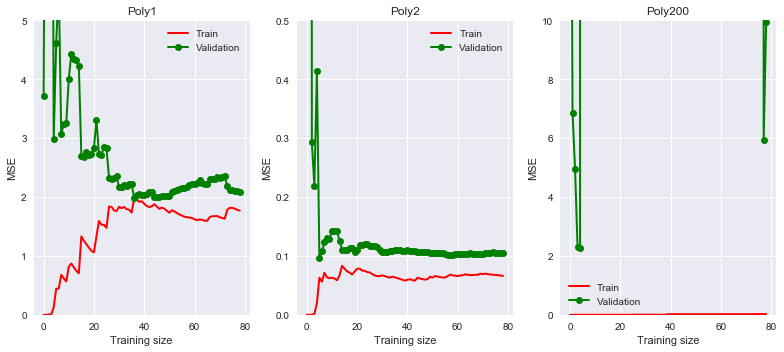

In [142]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model,X,y,ax=None,title=None):
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)
    train_errors=[];val_errors=[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_pred  = model.predict(X_train[:m])
        y_val_pred    = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_pred,y_train[:m]))
        val_errors.append(mean_squared_error(y_val_pred,y_val))
    if ax is None:
        fig,ax = plt.subplots(1,figsize=[5,4])
    ax.plot(train_errors,'r-+',lw=2,label='Train')
    ax.plot(val_errors,'g-o',lw=2,label='Validation')
    ax.set_xlabel('Training size'); ax.set_ylabel('MSE')
    if title is None: title='Learning Curves'
    ax.legend()
    ax.set_title(title)
    return ax

fig,axes = plt.subplots(1,3,figsize=[11,5])
ax1=plot_learning_curves(linreg,X,y,ax=axes[0],title='Poly1')
ax1.set_ylim([0,5])
ax2=plot_learning_curves(poly2,X,y,ax=axes[1],title='Poly2')
ax2.set_ylim([0,0.5])
ax3=plot_learning_curves(poly200,X,y,ax=axes[2],title='Poly200')
ax3.set_ylim([0,10])
fig.tight_layout()


We can explain the 1st degree polynomial case first. Performance on the training data is 0 or near 0 when there are only a few instances as the model can fit them perfectly, but as more instances are added the model can no longer achieve perfection on the training data because the data is noisy and the underlying shape is not linear. After 40 instances, the training errors levels off as adding new instances does not make the error any less. Performance on the validation data starts off extremely poor (high MSE) as using only a handful of instances cannot generalize well. As the model is shown more instances, the validation performance increases (MSE decreases) and plateaus. This is an example of underfitting as the training and validation errors are close and high. The way to improve underfitting models is to improve their complexity or add more features (adding more instances will not help).

In the middle, we see the large reduction in error from using the 2nd degree polynomial model, the two curves look similar to the 1st degree one but are much smaller error. They are close enough and low enough error that the model is doing a good job.

The right plot with a 200 degree polynomial shows overfitting. The training error is 0 and does not change with adding instances, and there is a large distance to the validation curve indicating that the model is significantly better on training data than validation data. Ways to fix the overfitting is to reduce model complexity, adding regularization, and adding more training data. 

### The Bias/Variance Tradeoff:

*Bias*: The part of the generalization error that is due to wrong assumptions, such as assuming the data is linear when it is actually quadratic. A high-bias model is most likely underfitting the training data.

*Variance*: The part due the model's excessive sensitivity to small variations in the training data. A model with a large number of degrees of freedom (high degree polynomial) is likely to have high variance, and thus overfit the training data.

*Irreducible error*: The part due to the noise in the data itself. The only way to reduce this is to clean up the data, for example by improving collection by fixing broken sensors. 

Increasing a model's complexity will commonly increase its variance and reduce the bias. Conversely, reducing the complexity will decrease the variance and increase the bias. 

## 5. Regularized Linear Models<a class="anchor" id="regular"></a>
[[back to top]](#top)

As mentioned above, one way to reduce overfitting is to regularize the model, this means to constrain it so that it is harder to overfit the data. For linear models, regularization is usually through constraining the weights/coefficients. 

### 5.A Ridge Regression<a class="anchor" id="ridge"></a>

Ridge regression, also known as *Tikhonov regularization* is a regularized version of Linear Regression. A regularization/penalty term is added to the cost function that is equal to:

$\alpha\sum^{n}_{i=1} \theta^{2}_i$.

Depending the degree of regularization, controlled by the parameter $\alpha$, the learning algorithm is forced to fit the data and keep the weights as small as possible. Note that the regularization term is only added to the cost function during training, and that once the model is trained, the performance can be evaluated using unregularized performance metrics.

> It is common that the cost function for training is different from the performance metric used in the problem. An example is a classifier trained using a cost function such as log loss, but evaluated with precision/recall.

If $\alpha=0$ then it is just Linear Regression. If $\alpha$ becomes infinitely large then the weights approach zero, and you end up with a flat line going through the data's mean. The cost function is then:

$J(\theta) = MSE(\theta) + \frac{\alpha}{2}\sum^{n}_{i=1} \theta^{2}_i $.

It is important to note that $i$ starts at 1 and not 0, so that the bias term $\theta_0$ is not regularized. We can rewrite the above if we define $w$ to be the feature weight vector spanning $\theta_1$ to $\theta_n$:

$J(\theta) = MSE(\theta) + \frac{\alpha}{2}(\lVert w \rVert_{\ell_{2}})^2 $, where

the $\lVert w \rVert_{\ell_{2}}$ function is the $\ell_2$ norm which is equal to $\sqrt{ \theta_1^2 + \theta_2^2 + \cdots + \theta_n^2}$.

> Note that regularized models are sensitive to the scale of the input data, and scaling should be done prior to training.

As we saw earlier with Linear Regression, where we could solve it analytically by using the Normal Equation or iteratively using Gradient Descent, the same can be done with Ridge Regression. The closed form solution is equal to:

$\hat{\theta} = (X^T\cdot X + \alpha A)^{-1} \cdot X^T \cdot y$,

where $A$ is a $n\times n$ identity matrix with a 0 in the top left entry for the bias term. 

Let's make some data and then perform Ridge Regression: 



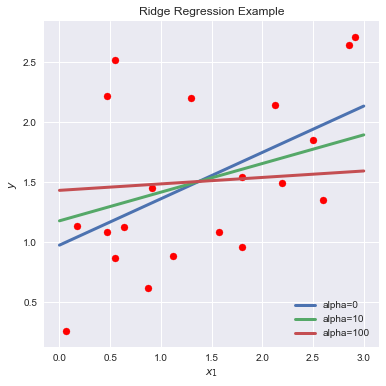

In [160]:
# Data
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

# Analytic Ridge Regression and plot results
fig,ax=plt.subplots(1,figsize=[6,6])
Xs = np.c_[np.ones((m,1)),X] # add bias column
X_news = np.c_[np.ones((100,1)),X_new]
A  = np.identity(Xs.shape[-1]); A[0,0] =0
ax.scatter(X,y,color='r')
# Iterate over alphas
for alpha in [0,10,100]:
    theta_hat = np.linalg.inv(Xs.T.dot(Xs) + alpha*A).dot(Xs.T).dot(y) #cholesky equation
    y_pred = X_news.dot(theta_hat)
    ax.plot(X_new,y_pred,label='alpha={}'.format(alpha),lw=3.0)
ax.legend();ax.set_xlabel(r'$x_1$');ax.set_ylabel(r'$y$')    
ax.set_title('Ridge Regression Example')

For this example of ridge regression where we solved the closed-form equation, we can see that increasing $\alpha$ leads to more of flat line as the coefficient (slope) is more constrained. 

`sklearn` has a class for Ridge Regression called `Ridge` where you can input $\alpha$ and also the method to solve the regression. The one we used above is called `cholesky`. Though you can also use the `SGDRegressor` we used earlier, but add a penalty term `l2`, to perform Stochastic Gradient Descent.  Let's test these out:

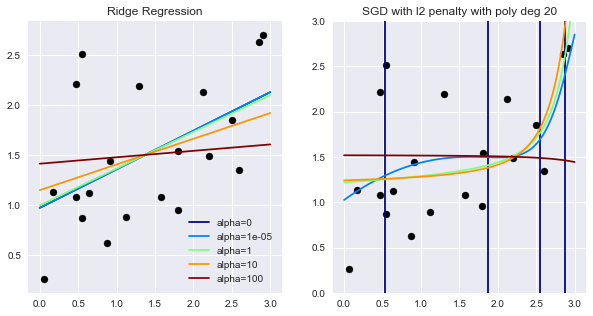

In [192]:
from sklearn.linear_model import Ridge
from sklearn.base import clone

# 1: Ridge regression
ridgereg    = Pipeline([('scaler', StandardScaler() ),
                        ('ridge', Ridge() )] )

# 3: 200 deg polynomial
ridgepoly20 =  Pipeline([("poly20",PolynomialFeatures(degree=20,include_bias=False) ),
                          ('scaler', StandardScaler() ),
                          ("ridge", SGDRegressor(penalty='l2',n_iter=1000,eta0=0.1) )])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=[10,5])
ax1.scatter(X,y,color='k');ax2.scatter(X,y,color='k')
cm_subsection = np.linspace(0.0, 1.0, 5) 
colors = [ cm.jet(x) for x in cm_subsection ]
for alpha,color in zip( [0,1e-5,1,10,100],colors):
    # Ridge with Ridge
    ridge = clone(ridgereg); poly = clone(ridgepoly20)
    ridge.set_params(ridge__alpha=alpha)
    ridge.fit(X,y.ravel())
    # Ridge with SGD
    poly.set_params(ridge__alpha=alpha)
    poly.fit(X,y.ravel())
    # Predictions and plot
    y_pred_r = ridge.predict(X_new)
    y_pred_p = poly.predict(X_new)
    ax1.plot(X_new,y_pred_r,color=color,label='alpha={}'.format(alpha))
    ax2.plot(X_new,y_pred_p,color=color,label='alpha={}'.format(alpha))
ax1.set_title('Ridge Regression')
ax2.set_title('SGD with l2 penalty with poly deg 20')
ax2.set_ylim(0,3)
ax1.legend()

We can see we get the same results on the left as we did with our own Ridge Regression code. On the right, where we fit a 20 degree polynomial to the data using the `SGDRegressor` with $\ell_2$ penalty and different $\alpha$ values. We can see that that without large regularization, it overfits the data, but with regularization the fit has less variance.

### 5.B Lasso Regression<a class="anchor" id="lasso"></a>

*Least Absolute Shrinkage and Selection Operator* (Lasso) Regression, is another regularized version of Linear Regression; and adds a regularization term to the cost function, but instead uses the $\ell_1$ norm of the feature weight vector instead of half the square of the $\ell_2$ norm. The $\ell_1$ norm is equal to $|\theta_1|+ |\theta_2| + \cdots + |\theta_n|$, and the associated cost function is:

$J(\theta) = MSE(\theta) + \alpha \sum^{n}_{i=1} |\theta_i| $.

A strength of Lasso vs. Ridge is that Lasso tends to completely eliminate the weights of the least important features, so it performs feature selection and outputs a sparse model (with a few nonzero feature weights).

Let's redo what we had for Ridge regression but this time use Lasso.

/Users/Justin/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/Users/Justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/Justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Justin/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/Users/Justi

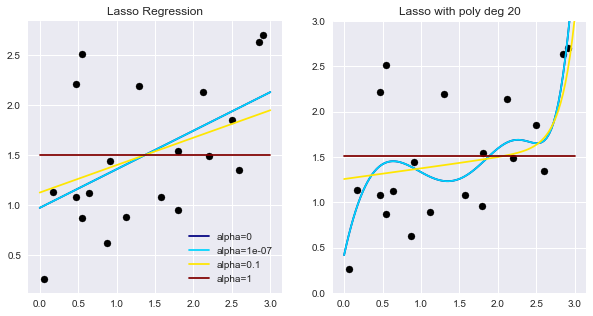

In [205]:
from sklearn.linear_model import Lasso

# 1: Lasso regression
lassoreg    = Pipeline([('scaler', StandardScaler() ),
                        ('lasso', Lasso() )] )

# 3: 200 deg polynomial
lassopoly20 =  Pipeline([("poly20",PolynomialFeatures(degree=20,include_bias=False) ),
                          ('scaler', StandardScaler() ),
                          ("lasso", Lasso(max_iter=10000) )])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=[10,5])
ax1.scatter(X,y,color='k');ax2.scatter(X,y,color='k')
cm_subsection = np.linspace(0.0, 1.0, 4) 
colors = [ cm.jet(x) for x in cm_subsection ]
for alpha,color in zip( [0,1e-7,0.1,1],colors):
    # Lasso on linear
    lasso = clone(lassoreg); poly = clone(lassopoly20)
    lasso.set_params(lasso__alpha=alpha)
    lasso.fit(X,y.ravel())
    # Lasso on polynomial
    poly.set_params(lasso__alpha=alpha)
    poly.fit(X,y.ravel())
    # Predictions and plot
    y_pred_r = lasso.predict(X_new)
    y_pred_p = poly.predict(X_new)
    ax1.plot(X_new,y_pred_r,color=color,label='alpha={}'.format(alpha))
    ax2.plot(X_new,y_pred_p,color=color,label='alpha={}'.format(alpha))
ax1.set_title('Lasso Regression')
ax2.set_title('Lasso with poly deg 20')
ax2.set_ylim(0,3)
ax1.legend()

Smaller $\alpha$ values are used above. In the right plot, we see that as alpha becomes larger it looks to be of just a 2nd order polynomial, showing that some of the higher order features are set to zero.

The Lasso cost function is not differentiable at $\theta_i=0$ (for $i=1,2,\cdots,n$), but Gradient Descent still works if a subgradient vector $g$ is used when any $\theta_i=0$. The subgradient vector for Lasso Regression looks like:

$g(\theta,J) = \nabla_\theta MSE(\theta) + \alpha \begin{pmatrix}
sign(\theta_1) \\
sign(\theta_2)  \\
                  \vdots        \\
sign(\theta_n)  \\
\end{pmatrix}$ where $ sign(\theta_i) = \left\{
\begin{array}{l,c,l}
      -1,& if& \theta_i <  0 \\
      0, &if &\theta_i =  0 \\
      1, & if& \theta_i >  0 \\
\end{array} 
\right.$

You can also use `SGDRegressor(penalty='l1')` for Stochastic Gradient Descent.

We will now look at the paths using Batch Gradient Descent with the additional penalties in the cost function.

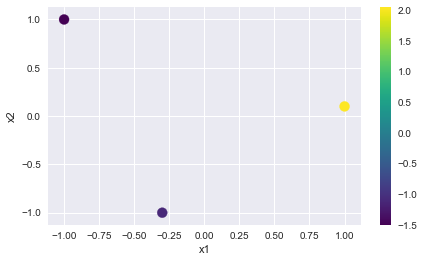

In [249]:
# Plot cost function with MSE and penalty terms separate one in contours and other in filled 
# contours

# Data and plot
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]
plt.figure(figsize=[7,4])
plt.scatter(Xr[:,0],Xr[:,1], c=yr,s=100,cmap='viridis')
plt.colorbar();plt.xlabel('x1');plt.ylabel('x2')

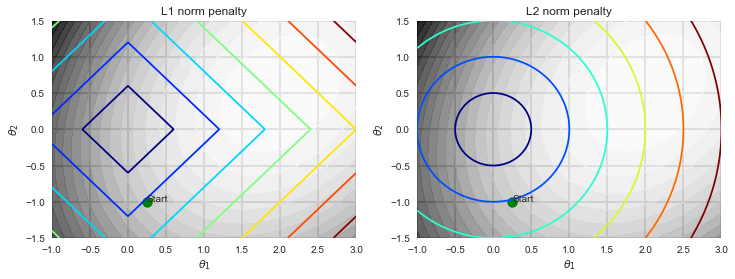

In [256]:
# Generate theta weight grid
thetas1 = np.linspace(-1, 3, 500)
thetas2 = np.linspace(-1.5,1.5, 500)
theta1, theta2 = np.meshgrid(thetas1, thetas2)
Thetas  = np.c_[theta1.ravel(), theta2.ravel()]

# Calculate cost function with only MSE and no bias terms meshgrid
m = len(Xr)
J = (1/m * np.sum((Thetas.dot(Xr.T) - yr.T)**2, axis=1)).reshape(theta1.shape)

# Calculate l1 and l2 norm for the coeficients
N1 = np.linalg.norm(Thetas, ord=1, axis=1).reshape(theta1.shape)
N2 = np.linalg.norm(Thetas, ord=2, axis=1).reshape(theta1.shape)

# Intialize
theta0= np.array([[0.25], [-1]])

#Plot cost function contours with l1 and l2 norms
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[12,4])
[ax.grid(color='k', linestyle='-', linewidth=2) for ax in[ax1,ax2]]
ax1.contourf(theta1, theta2, J, 20,alpha=0.9)
ax1.set_xlabel(r'$\theta_1$');ax1.set_ylabel(r'$\theta_2$')
ax1.contour(theta1, theta2, N1, cmap='jet')
ax1.scatter(theta0[0],theta0[1],color='g',s=100);ax1.annotate('Start', (theta0[0],theta0[1]))
ax1.set_title('L1 norm penalty')
ax2.contourf(theta1, theta2, J,20, alpha=0.9)
ax2.set_xlabel(r'$\theta_1$');ax2.set_ylabel(r'$\theta_2$')
ax2.contour(theta1, theta2, N2, cmap='jet')
ax2.scatter(theta0[0],theta0[1],color='g',s=100);ax2.annotate('Start', (theta0[0],theta0[1]))
ax2.set_title('L2 norm penalty')

The filled contour in the background above is the cost function for only the MSE. The contour lines are the $\ell_1$ and $\ell_2$ penalties. Now let's plot the path to the optimal minimum from the starting point shown above, if we consider the MSE and bias term separately first. First we need a function to perform Batch Gradient Descent, we will use $\alpha=0.5$ for both $\ell_1$ and $\ell_2$:

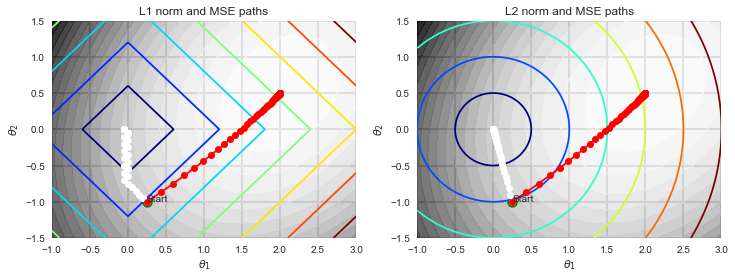

In [272]:
# Uses batch gradient descent to solve for theta with additional regularization
def bgd_path(theta, X, y, l1, l2, mse = 1, eta = 0.1, n_iterations = 100):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = mse * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

# BGD for the following cases:
# A) L1 penalty only
l1path = bgd_path(theta0, Xr,yr,l1=0.5,l2=0,mse=0)

# B) L2 penalty only
l2path = np.array(bgd_path(theta0, Xr,yr,l1=0,l2=0.5,mse=0) )

# C) MSE only
msepath = np.array( bgd_path(theta0, Xr,yr,l1=0,l2=0,mse=1) )

# Make plots like before but now with path
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[12,4])
[ax.grid(color='k', linestyle='-', linewidth=2) for ax in[ax1,ax2]]
ax1.contourf(theta1, theta2, J, 20,alpha=0.9)
ax1.set_xlabel(r'$\theta_1$');ax1.set_ylabel(r'$\theta_2$')
ax1.contour(theta1, theta2, N1, cmap='jet')
ax1.scatter(theta0[0],theta0[1],color='g',s=100);ax1.annotate('Start', (theta0[0],theta0[1]))
ax1.set_title('L1 norm and MSE paths')
ax2.contourf(theta1, theta2, J,20, alpha=0.9)
ax2.set_xlabel(r'$\theta_1$');ax2.set_ylabel(r'$\theta_2$')
ax2.contour(theta1, theta2, N2, cmap='jet')
ax2.scatter(theta0[0],theta0[1],color='g',s=100);ax2.annotate('Start', (theta0[0],theta0[1]))
ax2.set_title('L2 norm and MSE paths')
#------------- Plotting paths -------------#
ax1.plot(l1path[:,0],l1path[:,1],'wo',ls='-') #l1norm
ax2.plot(l2path[:,0],l2path[:,1],'wo',ls='-') #l2norm
ax1.plot(msepath[:,0],msepath[:,1],'ro',ls='-') #l1norm
ax2.plot(msepath[:,0],msepath[:,1],'ro',ls='-') #l2norm

The white line above shows the $\ell_1$ and $\ell_2$ paths to the minimum (0,0). Note the difference where $\ell_1$ first jumps to $\theta_1=0$ before descending down, it jumps around quite a bit because the gradient changes abruptly at zero. 

Now let's combine the MSE and norms to perform Ridge and Lasso regression and look at the paths:

Lasso final thetas: [[ 1.50744442  0.01158975]]
Ridge final thetas: [[ 1.10300713  0.13299267]]


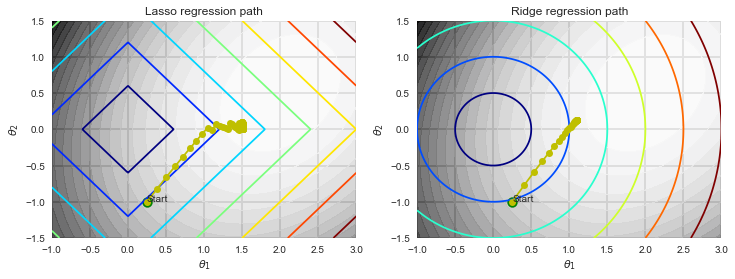

In [273]:
# BGD for the following cases:
# A) Lasso regression
lassopath = bgd_path(theta0, Xr,yr,l1=0.5,l2=0,mse=1)

# B) Ridge regression
ridgepath = np.array(bgd_path(theta0, Xr,yr,l1=0,l2=0.5,mse=1) )

# Make plots like before but now with path
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[12,4])
[ax.grid(color='k', linestyle='-', linewidth=2) for ax in[ax1,ax2]]
ax1.contourf(theta1, theta2, J, 20,alpha=0.9)
ax1.set_xlabel(r'$\theta_1$');ax1.set_ylabel(r'$\theta_2$')
ax1.contour(theta1, theta2, N1, cmap='jet')
ax1.scatter(theta0[0],theta0[1],color='g',s=100);ax1.annotate('Start', (theta0[0],theta0[1]))
ax1.set_title('Lasso regression path')
ax2.contourf(theta1, theta2, J,20, alpha=0.9)
ax2.set_xlabel(r'$\theta_1$');ax2.set_ylabel(r'$\theta_2$')
ax2.contour(theta1, theta2, N2, cmap='jet')
ax2.scatter(theta0[0],theta0[1],color='g',s=100);ax2.annotate('Start', (theta0[0],theta0[1]))
ax2.set_title('Ridge regression path')
#------------- Plotting paths -------------#
ax1.plot(lassopath[:,0],lassopath[:,1],'yo',ls='-') #lasso
ax2.plot(ridgepath[:,0],ridgepath[:,1],'yo',ls='-') #ridge

print('Lasso final thetas:',lassopath[-1,:].T)
print('Ridge final thetas:',ridgepath[-1,:].T)

As we can see for Lasso regression it tries to completely eliminate some weights, $\theta_2$ above. For both Lasso and Ridge, the regularized global minimum is closer to (0,0) than the unregularized case, but the weights are not fully eliminated.

By increasing the strength of the regularization, the cost function minimum will move closer to (0,0).

### 5.C Elastic Net Regression<a class="anchor" id="elastic"></a>

Elastic Net is a combination of both Ridge and Lasso regression. This means that the regularization term is a simple mix of both Ridge and Lasso's penalty terms. There is a parameter, $r$, that controls the mix ratio. When $r=0$ Elastic Net is the same as Ridge Regression, and when $r=1$ it is the same as Lasso:

$J(\theta) = MSE(\theta) +r\alpha\sum^{n}_{i=1}|\theta_i| + \frac{1-r}{2}\alpha\sum^{n}_{i=1}\theta_i^2$

When should Linear, Ridge, Lasso or Elastic Net Regressions be used? It is always preferable to have some regularization, so can avoid Linear. Ridge is a good default, but if there are only a few features that might be relevant then Lasso or Elastic Net may be useful. 

Elastic Net is preferred to Lasso when the number of features, $n$, outnumbers the number of training instances, $m$, or when several of the features are strongly correlated.

We can add in the $r$ mixing ratio into our previous example:

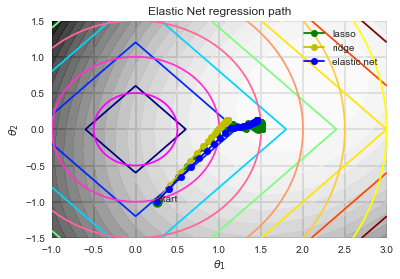

In [289]:
def bgd_elastic_net_path(theta, X, y, alpha, r, mse = 1, eta = 0.1, n_iterations = 100):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = mse * 2/len(X) * X.T.dot(X.dot(theta) - y) + alpha *r* np.sign(theta) + (1-r)*alpha * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

elasticpath = np.array(bgd_elastic_net_path(theta0, Xr,yr,alpha=0.5,r=0.5,mse=1) )

# Make plots like before but now with path
fig,ax1 = plt.subplots(1,1,figsize=[6,4])
ax1.grid(color='k', linestyle='-', linewidth=2)
ax1.contourf(theta1, theta2, J, 20,alpha=0.9)
ax1.set_xlabel(r'$\theta_1$');ax1.set_ylabel(r'$\theta_2$')
ax1.contour(theta1, theta2, N1, cmap='jet')
ax1.contour(theta1, theta2, N2, cmap='spring')
ax1.scatter(theta0[0],theta0[1],color='g',s=100);ax1.annotate('Start', (theta0[0],theta0[1]))
ax1.set_title('Elastic Net regression path')
#------------- Plotting paths -------------#
ax1.plot(lassopath[:,0],lassopath[:,1],'go',ls='-',label='lasso') #lasso
ax1.plot(ridgepath[:,0],ridgepath[:,1],'yo',ls='-',label='ridge') #ridge
ax1.plot(elasticpath[:,0],elasticpath[:,1],'bo',ls='-',label='elastic net') #elastic net
ax1.legend()

The `sklearn` class `ElasticNet` has parameters `alpha` and `l1_ratio` that corresponds to $r$.


### 5.D Early Stopping<a class="anchor" id="early"></a>

Instead of stopping iterative learning schemes, like Gradient Descent, when the tolerance (or gradient vector) becomes small, another way is to stop training as soon as the validation error reaches a minimum.

We will show this below with a high degree polynomial regression using stochastic gradient descent:

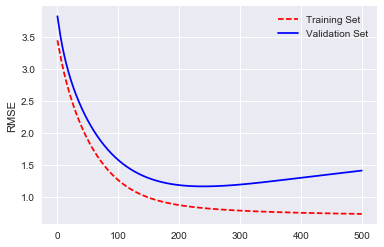

In [296]:
# Generate some data
from sklearn.base import clone
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline((
             ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
             ("std_scaler", StandardScaler()),
              ))
# the warm_start=True allows the the regressor to continue where it left off instead of restarting
# from scratch when fit is called
sgd_reg = SGDRegressor(n_iter=1,penalty=None,eta0=0.0005,warm_start=True,learning_rate="constant",
                       random_state=42)

sgd_pipe = Pipeline([ ('prepare',poly_scaler),
                      ('reg', clone(sgd_reg))])

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_pipe.fit(X_train, y_train)
    y_train_predict = sgd_pipe.predict(X_train)
    y_val_predict = sgd_pipe.predict(X_val)
    train_errors.append(mean_squared_error(y_train_predict, y_train))
    val_errors.append(mean_squared_error(y_val_predict, y_val))

# Plot
plt.plot(range(n_epochs),np.sqrt(train_errors),'r--',label='Training Set')
plt.plot(range(n_epochs),np.sqrt(val_errors),'b',label='Validation Set')
plt.legend()
plt.xlabel='Epochs';plt.ylabel('RMSE')

Above we see that as the epochs increase, the error on the training set and validation set goes down. But after around 250 epochs/iterations, the model begins to overfit the training data (validation error increases). 

With **early stopping** you can stop the training as soon as the validation error reaches the minimum. With Stochastic and Mini-batch Gradient Descent, the curves might not be perfectly smooth, so to determine when the minimum has been reached, you could stop when the validation error has been above the minimum for a certain number of epochs, and choose the model parameters at the minimum.

Below is an implementation of early stopping:

In [299]:
from sklearn.base import clone

sgd_pipe =  Pipeline([ ('prepare',poly_scaler),
                      ('reg', clone(sgd_reg))])

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(500):
    sgd_pipe.fit(X_train,y_train) # continues where left off
    y_val_pred = sgd_pipe.predict(X_val)
    val_error = mean_squared_error(y_val_pred,y_val)
    if val_error < minimum_val_error:
        minimum_val_error= val_error
        best_epoch= epoch
        best_model= clone(sgd_pipe)
    else:
        break 

print('Best epoch: ', best_epoch)
print('Best model: ', sgd_pipe.steps[-1])

Best epoch:  239
Best model:  ('reg', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', n_iter=1, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=True))


Can see that the minimum validation error is at 239 epochs.

## 6. Logistic Regression<a class="anchor" id="logistic"></a>
[[back to top]](#top)

Logistic Regression is commonly used to estimate the probability that an instance belongs to a particular class. If the estimated probability is greater than 50%, the model predicts that the instance belongs to that class (1) or else it predicts that it does not (0), thus making it a binary classifier. 

### Estimating Probabilities

Similar to Linear Regression, Logistic Regression computes the weighted sum of input features (plus a bias term), but instead of outputting the result directly like Linear Regression, it outputs the *logistic* of the result.

$\hat{p} = h_\theta(x) = \sigma(\theta^T\cdot x)$,

where $\hat{p}$ is the estimated probability that an instance $x$ belongs to the positive class. The $\sigma$ function is called the logistic/logit, which is a sigmoid function (S shaped) that outputs a number between 0 and 1, and is equal to:

$\sigma(t) = \frac{1}{1+e^{-t}}$

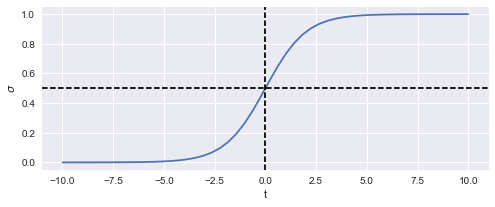

In [306]:
# Plot sigmoid function
t     = np.linspace(-10,10,50)
sigma = 1./(1+np.exp(-t))
fig,ax= plt.subplots(1,figsize=[8,3])
ax.plot(t,sigma);ax.set_xlabel('t');ax.set_ylabel(r'$\sigma$')
ax.axvline([0],color='k',ls='--');ax.axhline([0.5],color='k',ls='--')

After the Logistic Regression model has estimated the probability, it can make the prediction $\hat{y}$ simply by:

$\hat{y} = \left\{
\begin{array}{l,c,l}
      0,& if & \hat{p} <  0.5, \\
      1, &if &\hat{p} \geq 0.5 \\
\end{array} 
\right. $

Note that the above is equivalent to $\sigma(t) < 0.5$ when $t < 0$ or $\theta^T\cdot x < 0$. So the Logistic Regression model predicts 1 if $\theta^T\cdot x$ is positive and 0 if it is negative.

### Training and Cost Function

The objective of training is to set the weight vector $\theta$ so that the model estimates high probabilities for positive instances ($y=1$) and low probabilities for negative instances ($y=0$), and can be estimated by the cost function:

$c(\theta) =  \left\{
\begin{array}{l,c,l}
      -\log{(\hat{p})},& if & y=1, \\
      -\log{(1- \hat{p})}, &if &y=0\\
\end{array} 
\right. $

$-\log{(p)}$ grows very large when $p$ approaches 0 (becomes small), so the cost will be large if the model estimates a probability close to 0 for a positive instance ($y=1$). The cost will also be very large if the model estimates a probability close to 1 for a negative instance ($y=0$).

Conversely, the $-\log{(p)}$ will approach 0 when $p$ is close to 1, thus the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance.

The cost function over the whole training set is the average cost over all training instances, and can be written as:

$J(\theta) = -\frac{1}{m} \sum^m_{i=1}\left[y^{(i)}\log(\hat{p}^{(i)}) + (1-y^{(i)})\log(1-\hat{p}^{(i)}) \right]$,

which is called the **log loss**. Unlike for linear regression, there is no closed-form equation to calculate the value of $\theta$ that minimizes $J$. However, the cost function is convex, so optimization algorithms like Gradient Descent is guaranteed to find the global minimum, given adequate learning rate and iterations. 

The partial derivative of the cost function with respect to the j<sup>th</sup> model parameter $\theta_j$ is equal to:

$\frac{\partial}{\partial \theta_j} J(\theta) = \frac{1}{m} \sum^{m}_{i=1}(\sigma(\theta^T \cdot x^{(i)}) - y^{(i)})x^{(i)}_j$,

which looks the same as what we had for the partial derivatives for the MSE in Linear Regression. For each instance the estimated probability is computed and multiplied by the j<sup>th</sup> feature value, and then it computes the average over all training instances. Once the gradient vector is calculated, Batch Gradient Descent can be implemented. For Stochastic Gradient Descent, one instance at a time would be used. 

### Decision Boundaries

For this example we will use the famous iris dataset for Logistic Regression. The dataset contains the sepal and petal length and width of 150 iris flowers of 3 species:

    1. Iris-Setosa,
    2. Iris-Versicolor
    3. Iris-Virginica
    
We will train a classifier to detect if a flower is Iris-Virginica based only on the petal width feature. The dataset is built into `scikit-learn`:

In [309]:
from sklearn import datasets
iris = datasets.load_iris()
display( iris.keys() )
print( iris['DESCR'])

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

As we can see above the pedal width correlation with the class is very high and is the reason we will only use it for this example to train our Logistic Regressor: 

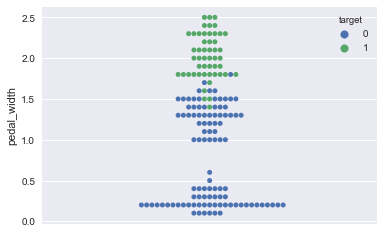

In [328]:
X = iris['data'][:,3:] # pedal width 
y = (iris['target'] ==2).astype(np.int) # if virginica class is 1 else 0

# Let's make a visualization looking at pedal width and class
data = pd.DataFrame(X,columns=['pedal_width'])
data['target'] = y 

sns.swarmplot(y=data['pedal_width'],hue=data['target'],x=[""]*len(data))

We can see from the above that for a pedal width greater than around 1.5 the occurrence of virginica is much higher. We'll now train a Logistic Regression model using `sklearn`:


In [329]:
from sklearn.linear_model import LogisticRegression

#Train model
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The trained classifier can predict the probabilities associated with new instances, let's look at pedal widths ranging from 0 to 3cm.

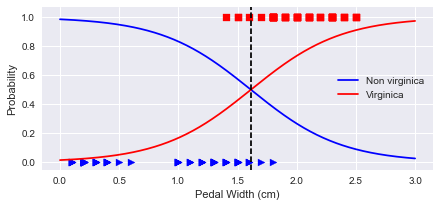

In [354]:
X_new = np.linspace(0,3,500).reshape(-1,1) 
# Predict probabilities
y_proba = log_reg.predict_proba(X_new)
# Plot the data and probability curves together
fig,ax = plt.subplots(1,figsize=[7,3])
virg_widths = X[(y==1),0]; nonvirg_widths=X[(y==0),0]
ax.scatter(virg_widths,np.ones(len(virg_widths)),color='r',marker='s')
ax.scatter(nonvirg_widths,np.zeros(len(nonvirg_widths)),color='b',marker='>')
ax.set_xlabel('Pedal Width (cm)');ax.set_ylabel('Probability')
ax.plot(X_new,y_proba[:,0],'b',label='Non virginica')
ax.plot(X_new,y_proba[:,1],'r',label='Virginica')
# Plot decision boundary 
decision_width = X_new[(y_proba[:,1]>=0.5),0][0]
ax.axvline(decision_width,color='k',ls='--')
ax.legend(frameon=False)

We can see above the training data that are classified as Iris-virginica or not, along with the probability curves for the two classes. Where the probabilities are equal to 0.50 is where the logistic regressor draws the decision boundary. If the pedal width is greater than 1.6 cm the classifier will predict Iris-virginica even if it is not confident. We can also see the training points that would be misclassified by the classifier.

Now let's look at more than one feature, and also include the pedal length:

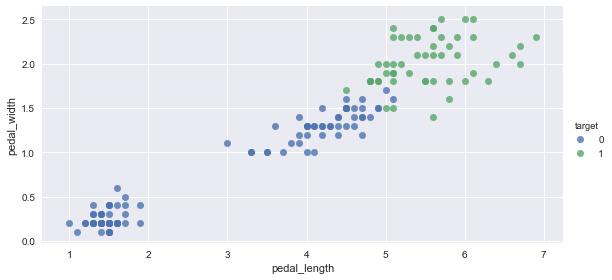

In [360]:
# Pedal length and width data
X = iris['data'][:,2:] # pedal length and width

# Make a scatter plot
data = pd.DataFrame(X,columns=['pedal_length','pedal_width'])
data['target'] = y 
sns.lmplot(x='pedal_length',y='pedal_width',hue='target',data=data,fit_reg=False,aspect=2,size=4)

We can look at decision boundaries for both pedal length and width:

In [385]:
def classifier_boundary_2d(classifier,X):
    step_size = 0.05
    maxs  = X.max(axis=0)
    mins  = X.min(axis=0)
    x1,x2 = np.meshgrid(np.arange(mins[0]-step_size,maxs[0]+2*step_size,step_size), np.arange(mins[1]-step_size,maxs[1]+2*step_size,step_size))
    output = classifier.predict(np.c_[x1.ravel(),x2.ravel()])
    output = output.reshape(x1.shape)
    return x1,x2,output

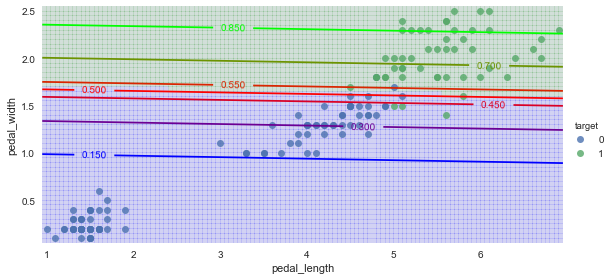

In [389]:
from matplotlib import colors as c

# Train model
log_reg = LogisticRegression()
log_reg.fit(X,y)
# Grid for predictions
lengths,widths,output = classifier_boundary_2d(log_reg,X)
sns.lmplot(x='pedal_length',y='pedal_width',hue='target',data=data,fit_reg=False,aspect=2,size=4)
cmap= c.ListedColormap(['b','g'])
plt.pcolormesh(lengths,widths,output,cmap=cmap,zorder=0,alpha=0.1)
Xnew=np.c_[lengths.ravel(),widths.ravel()]
y_proba = log_reg.predict_proba(Xnew)
zz = y_proba[:, 1].reshape(lengths.shape)
contour = plt.contour(lengths, widths, zz, cmap=plt.cm.brg,levels=[0.15,0.3,0.45,0.5,0.55,0.7,0.85])
labs=plt.clabel(contour, inline=1, fontsize=10)



We can see the boundaries for probability associated with the classifier that the class is Iris-virginica. 

Similar to the previous linear regression models discussed, Logistic Regression models can be regularized using $\ell_1$ and $\ell_2$ penalties. The default for `sklearn` for Logistic Regression is to add an $\ell_2$ penalty. It should be noted that the hyperparameter that controls the regularization strength for `LogisticRegression` is not `alpha` but `C` which the inverse of `alpha`. Thus a higher `C` corresponds to less regularization. 


## 7. Softmax Regression<a class="anchor" id="softmax"></a>
[[back to top]](#top)

The Logistic Regression model can be made to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called **Softmax Regression** (Multinomial Logistic Regression). When given an instance $x$, Softmax Regression computes a score, $s_k(x)$ for each class $k$, and estimates the probability of each class by applying the *softmax function* to the scores. 

The equation for computing $s_k(x)$ is the same as the equation for the prediction for Linear Regression:

$s_k(x) = \theta_k^T\cdot x$,

where each class has its own parameter vector $\theta_k$, which are stored as rows in a parameter matrix, $\Theta$.

After computing the scores of every class for instance, $x$, the probability, $\hat{p_k}$, that the instance belongs to class $k$ can be estimated by running the scores through the *softmax function*:

$\hat{p_k} = \sigma( \textbf{s}(x))_k = \frac{\exp{(s_k(x))}}{\sum_{j=1}^K \exp (s_j(x))} $, where

* $K$ is the number of classes.
* $\textbf{s}(x)$ is a vector containing the scores of each class for the instance $x$.
* $\sigma( \textbf{s}(x))_k$ is the estimated probability that instance $x$ belongs to class $k$ given the scores of each class for that instance.

It computes the exponentials for every score, then normalizes them (dividing by the sum of all the exponentials), and is why the *softmax function* is also called the normalized exponential. 

Similar to Logistic Regression, the Softmax Regression classifier predicts the class with the highest estimated probability, which is the same as the class with the highest score:

$\hat{y} = $ argmax $ \sigma( \textbf{s}(x))_k$ = argmax $s_k(x) = $argmax$ (\theta_k^T\cdot x) $,

where argmax operator returns the value of a variable that maximizes a function. Here it returns the value of $k$ that maximizes the estimated probability of $ \sigma( \textbf{s}(x))_k$.

> Softmax Regression is multiclass but not multioutput, so only predicts one class at a time and should only be used with mutually exclusive classes. E.g. should not be used for facial recognition of multiple people in one photo. 

### Training Softmax Regression

The objective is for a model that estimates a high probability for the target class, and low probability for the other classes. The objective function is called **cross entropy**, which penalizes the model when it estimates a low probability for a target class. Cross entropy is used to measure how well a set of estimated class probabilities match the target classes.

> **Cross entropy**: If you want to transmit efficiently information about the weather each day, and there are eight options (sunny, rainy, etc), you could encode each option using 3 bits since $2^3 = 8$. E.g. 000 = sunny, 001 = rainy..., 111 = cloudy. But if it will be sunny on most days, it would be more efficient to encode sunny on one bit (0). If it isn't sunny then the sunny bit can be set to (1) and have the other 7 options on 3 other bits. Cross entropy measures the average number of bits you actually send per option. If the assumption about weather is perfect then cross entropy will be equal to the entropy of the weather itself. But if the assumption is wrong then cross entropy will be greater by an amount called *Kullback-Leibler divergence*. The cross entropy between two distributions $p$ and $q$ is equal to $H(p,q) = -\sum_x p(x) \log q(x)$

The cross entropy cost function equation is equal to:

> $J(\Theta) = - \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K y_k^{(i)}\log(\hat{p_k}^{(i)})$,

note that $y_k^{(i)}$ is equal to 1 if the target class for the i<sup>th</sup> instance is $k$; otherwise it is set to 0. If $K=2$ the above equation becomes:

$ J(\Theta) =-\frac{1}{m} \sum^m_{i=1} y_1^{(i)}\log(\hat{p_1}^{(i)}) + y_0^{(i)}\log(\hat{p_0}^{(i)})
= -\frac{1}{m} \sum^m_{i=1} \left[y^{(i)}\log(\hat{p}^{(i)}) + (1-y^{(i)})\log(1-\hat{p}^{(i)}) \right] $ 

since $\hat{p_0} = 1-\hat{p_1}$ and  $y_1 = 1-y_0$ for a binary classification problem and the above is reduced to the Logistic Regression log loss cost function.

The corresponding gradient vector with respect to $\theta_k$ is given by:

$\nabla_{\theta_k} J(\Theta) = \frac{1}{m} \sum_{i=1}^m ( \hat{p_k}^{(i)} - y_k^{(i)})x^{(i)}$,

so the gradient vector can be computed for every class, and Gradient Descent (or any other optimization method) to find the parameter matrix $\Theta$ that minimizes the cost function.


### Example with Iris dataset:

We will implement our own Softmax Regression using Batch Gradient Descent:


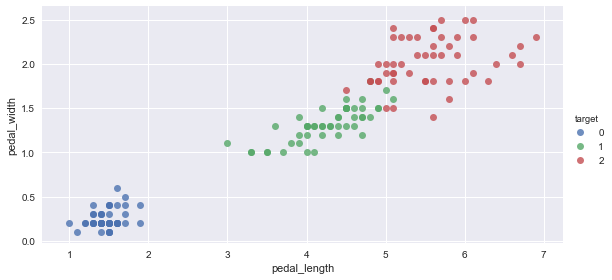

In [469]:
# Load Iris data
X = iris['data'][:,2:] # pedal length and width
y = iris['target'] # all classes this time

# Make a scatter plot
data = pd.DataFrame(X,columns=['pedal_length','pedal_width'])
data['target'] = y 
sns.lmplot(x='pedal_length',y='pedal_width',hue='target',data=data,fit_reg=False,aspect=2,size=4)

Now we can see all 3 classes now in terms of pedal length and width. 

Since we're doing the regression ourselves, we have to add the bias term to $X$:

In [451]:
# Add bias term
Xb = np.c_[np.ones(len(X)),X]
Xb.shape

(150, 3)

Next we'll split the dataset into training, validation and test sets, with a split of 60/20/20:

In [472]:
# Splitting into training, validation and test sets
X_train,X_valtest,y_train,y_valtest = train_test_split(Xb,y,test_size=0.4)
X_val,X_test,y_val,y_test  = train_test_split(X_valtest,y_valtest,test_size=0.5)

As mentioned earlier, for our target, each class probability will be equal to 0 except for the target class which will be equal to 1. This means we have to one-hot-encode our target vector:

In [474]:
from sklearn.preprocessing import OneHotEncoder
# One hot encode target vector
encoder = OneHotEncoder(sparse=False)
# Fit with training data
encoder.fit(y_train.reshape(-1,1))
# Return OHE for train,val and test
y_train_ohe = encoder.transform(y_train.reshape(-1,1))
y_val_ohe = encoder.transform(y_val.reshape(-1,1))
y_test_ohe = encoder.transform(y_test.reshape(-1,1))
y_train_ohe[0:10]

array([[ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]])

We can see above that the target vector is now one hot encoded.

Next we'll create a function for the Softmax function, previously defined as:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [476]:
# Softmax function
def softmax(scores):
    exps = np.exp(scores)
    exp_sum = np.sum(exps,axis=1,keepdims=True)
    return exps/exp_sum

# Define number of inputs/outputs
n = X_train.shape[1] #features
m = X_train.shape[0] #instances
K = encoder.n_values_[0] #unique classes
print('n: ',n,' m: ',m, ' K: ',K)

n:  3  m:  90  K:  3


Now we have to implement the cost function, and its gradient vectors. The equations we will need are the cost function:

$J(\mathbf{\Theta}) =-
\dfrac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

We should note that $\log(\hat{p}^{(i)}_k)$ cannot be computed if $\hat{p}^{(i)}_k=0$. The solution to this is to add a small value $\epsilon$ to $\log(\hat{p}^{(i)}_k)$ to avoid getting `NAN` values.

In [478]:
# Parameters
eta    = 0.01
n_iter = 5001
epsilon = 1e-7

#Initialize Theta
np.random.seed(42)
Theta = np.random.randn(n,K)

# Softmax Batch Gradient Descent
for itera in range(n_iter):
    scores = X_train.dot(Theta)
    y_proba = softmax(scores)
    loss  = -np.mean( np.sum(y_train_ohe*np.log(y_proba+epsilon),axis=1 ))
    error = y_proba - y_train_ohe
    if itera % 500==0:
        print('Iteration: ',itera,' Loss:',loss)
    gradients = 1./m *X_train.T.dot(error)
    Theta = Theta - eta*gradients

Iteration:  0  Loss: 7.58769936851
Iteration:  500  Loss: 0.894913866124
Iteration:  1000  Loss: 0.730755666779
Iteration:  1500  Loss: 0.637173033028
Iteration:  2000  Loss: 0.577481325616
Iteration:  2500  Loss: 0.535639870871
Iteration:  3000  Loss: 0.504183985156
Iteration:  3500  Loss: 0.479299223732
Iteration:  4000  Loss: 0.458859997692
Iteration:  4500  Loss: 0.441592101835
Iteration:  5000  Loss: 0.426684283662


Our Softmax model is trained, we can examine the weight matrix $\Theta$:

In [459]:
print(Theta)

[[ 3.66747319 -0.38772467 -2.27361013]
 [-0.46350788  0.95664598  0.56160142]
 [-0.48429096 -0.04810049  2.40956461]]


Next step is to make predictions for the validation set and check the accuracy:

In [479]:
from sklearn.metrics import accuracy_score

val_scores = X_val.dot(Theta)
yval_proba = softmax(val_scores)

# Predictions
yval_pred = np.argmax(yval_proba,axis=1)

# Check accuracy
print(accuracy_score(y_val,yval_pred))

0.866666666667


We can also add $\ell_2$ regularization into our Softmax Regression, we d that below and do not regularize the first column of $\Theta$ since it is the bias term. We also increase the learning rate $\eta$:

In [487]:
# Parameters
eta    = 0.01
n_iter = 5001
epsilon = 1e-7

#Initialize Theta
np.random.seed(42)
Theta = np.random.randn(n,K)

# Softmax Batch Gradient Descent with l2 regularization
for itera in range(n_iter):
    scores = X_train.dot(Theta)
    y_proba   = softmax(scores)
    crossentr_loss = -np.mean( np.sum(y_train_ohe*np.log(y_proba+epsilon),axis=1 ))
    l2_loss = 0.5*np.square( np.linalg.norm(Theta[1:]) )
    loss = crossentr_loss + alpha*l2_loss
    error = y_proba - y_train_ohe
    if itera % 500==0:
        print('Iteration: ',itera,' Loss:',loss)
    gradients = 1./m *X_train.T.dot(error) + np.r_[np.zeros([1,n]),alpha*Theta[1:]]
    Theta = Theta - eta*gradients

Iteration:  0  Loss: 10.4539709886
Iteration:  500  Loss: 0.928042718574
Iteration:  1000  Loss: 0.870286363198
Iteration:  1500  Loss: 0.847962769523
Iteration:  2000  Loss: 0.838741772033
Iteration:  2500  Loss: 0.83469327124
Iteration:  3000  Loss: 0.832823401118
Iteration:  3500  Loss: 0.831924609784
Iteration:  4000  Loss: 0.831479298886
Iteration:  4500  Loss: 0.83125368484
Iteration:  5000  Loss: 0.831137525035


Even though the loss seems greater than before, let's test it out on the validation set again:

In [482]:
val_scores = X_val.dot(Theta)
yval_proba = softmax(val_scores)

# Predictions
yval_pred = np.argmax(yval_proba,axis=1)

# Check accuracy
print('Accuracy score with l2 regularization: ',accuracy_score(y_val,yval_pred))

Accuracy score with l2 regularization:  0.833333333333


Now let's visualize the model's prediction on the whole dataset:

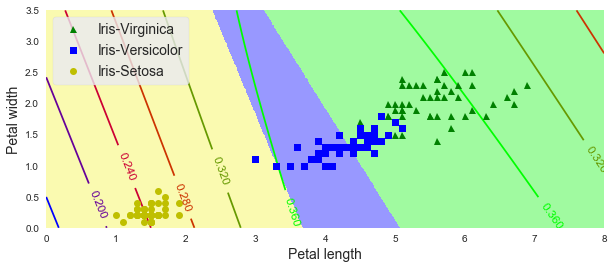

In [488]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

fig,ax = plt.subplots(1,figsize=[10,4])
ax.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
ax.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
ax.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

ax.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
contour = ax.contour(x0, x1, zz1, cmap=plt.cm.brg)
ax.clabel(contour, inline=1, fontsize=12)
ax.set_xlabel("Petal length", fontsize=14)
ax.set_ylabel("Petal width", fontsize=14)
ax.legend(loc="upper left", fontsize=14,frameon=True)
plt.show()

### Softmax with `sklearn`

We can implement Softmax Regression with `LogisticRegression`. By default it uses the one-versus-all approach, but you can set the hyperparameter `multi_class` to `multinomial` to swtich to Softmax Regression instead. The solver must be specified as well to `lbfgs` and $\ell_2$ regularization is default, with the parameter `C`:

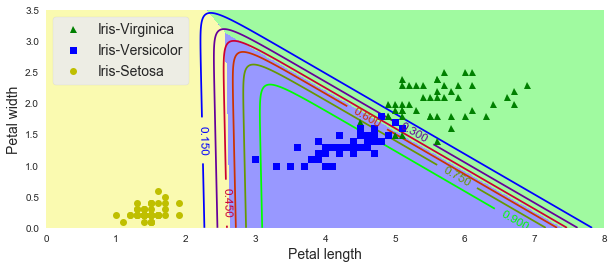

In [490]:
softmax_reg = LogisticRegression(multi_class='multinomial',solver='lbfgs',C=10)
softmax_reg.fit(X,y)

# Plot predictions
y_predict = softmax_reg.predict(X_new)
y_proba   = softmax_reg.predict_proba(X_new)
zz = y_predict.reshape(x0.shape)
zz1 = y_proba[:, 1].reshape(x0.shape)

fig,ax = plt.subplots(1,figsize=[10,4])
ax.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
ax.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
ax.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

ax.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
contour = ax.contour(x0, x1, zz1, cmap=plt.cm.brg)
ax.clabel(contour, inline=1, fontsize=12)
ax.set_xlabel("Petal length", fontsize=14)
ax.set_ylabel("Petal width", fontsize=14)
ax.legend(loc="upper left", fontsize=14,frameon=True)
plt.show()

## Exercise Questions

>**1.** What Linear Regression training algorithm can be used if you have a training set with millions of features?

The computational complexity for solving the Normal Equation for Linear Regression is $\mathcal{O}(n^{2.4)}$ so for a large number of $n$ greater than 100,000 it can bae quite slow. Thus for large $n$, Batch GD, Stochastic GD, and Mini-Batch GD would all be suitable.

>**2.** If the features in your training set have very different scales, what algorithms could suffer from this, and how? What can be done?

All of the Gradient Descent algorithms could suffer from features having large scale differences, this is because the path of the descent might not be the fastest, as differing scales can distort $\theta$ space. While it will eventually reach the minimum, with large scale differences it could take a long time. Also regularized models are sensitive to the scale of the input data as well because the norm of the weights could be biased towards features that have differing scales. An easy solution is to perform scaling prior to training the model, this can be done with `StandardScaler()` in `sklearn`. 

>**3.** Can Gradient Descent get stuck in a local minimum while training a Logistic Regression model?

The log loss cost function for Logistic Regression is convex, so optimization algorithms like Gradient Descent are guaranteed to find the global minimum, given adequate learning rate and iterations. So it cannot get stuck in a local minimum.

>**4.** Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?

The primary difference in the Gradient Descent algorithms is the speed of converging on the global minimum. Provided you have a learning schedule to change the learning rate, and a large enough number of iterations, then all Gradient Descent algorithms should lead to the same model.

>**5.** Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

If the validation error begins to consistently increase after some number of epochs, then this indicates that the model is beginning to overfit the training data, and is not generalizing well. This can be fixed by implementing **early stopage** where you can stop the training as soon as the validation error reaches the minimum, and select the model at the minimum.

>**6.** Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

With both Stochastic and Mini-batch Gradient Descent, the validation curves might not be perfectly smooth, so it is not a good idea to immediately stop when the validation error increases. To determine when the minimum has been reached, you could stop when the validation error has been above the minimum for a certain number of epochs, and choose the model parameters at the minimum.

>**7.** Which Gradient Descent algorithm  will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

Mini-batch GD will reach the vicinity of the optimal solution the fastest, this is because it computes gradients on a small random set of instances. Because of this there is a performance boost from hardware optimization of matrix operations. Batch Gradient Descent will actually converge on the optimal solution, while Stochastic GD and Mini-batch GD jump around the optimal solution. They can converge if the learning rate becomes smaller as the algorithm gets closer to the optimal solution, by looking when the gradient vector becomes small.

>**8.** Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

A large gap between the training error and the validation error indicates there is a large variance in the generalization, due to the model's excessive sensitivity to small variations in the training data. The model is overfitting the training data. The polynomial model with a large number of degrees of freedom is likely to have high variance, and thus overfit the training data. Three ways to solve this:
    1. Reduce the complexity of the model
    2. Regularize the model
    3. Add more training data
    
>**9.** Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance. Should you increase the regularization strength or reduce it?

Similar training and validation errors that are high indicate the model is underfitting the training data. Thus the model suffers from high bias which is the part of the generalization error that is due to wrong assumptions, such as assuming the data is linear when it is actually quadratic. One way to solve this for Ridge Regression would be to relax the strength of the regularization to increase the complexity of the model.

>**10.** Why would you use:
    1. Ridge Regression instead of Linear Regression
    2. Lasso instead of Ridge Regression
    3. Elastic Net instead of Lasso

1. If the learning curves indicate that Linear Regression is overfitting the training data, then it is good by default to introduce regularization with Ridge Regression to constrain it so that it is harder to overfit the data.
2. If there are only a few features that might be relevant to the regression, then Lasso could be preferred over Ridge Regression since Lasso has a tendency to completely eliminate the weights of the least important features, so it performs feature selection and outputs a sparse model.
3. Elastic Net is preferred to Lasso when the number of features,  $n$ , outnumbers the number of training instances,  $m$ , or when several of the features are strongly correlated.


>**11.** Suppose you want to classify pictures as outdoor/ indoor and daytime/ nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

 

## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).